## Project Goal: TF Model to Recognize Chinese Tones

Author: Andrew Denny

Credit for Dataset : [TonePerfect](https://tone.lib.msu.edu/)

Outline of My Process:

1. Visualize Spectrograms of a few Individual Recordings 
2. Create Spectrograms for All, and create TF Dataset
2. Use Forvo API to pull in some real world examples to help the model generalize better (after some experimentation, realized this would be useful)
3. Combine Datasets
4. Create Model 
5. View the Results
6. Practice Quantizing Model with TFLite (For practice putting a model on AWS Lambda)

In [ ]:
%pip install librosa tensorflow sklearn matplotlib numpy python-dotenv

In [2]:
import tensorflow as tf
import librosa 
import matplotlib.pyplot as plt
import os
import numpy as np


In [ ]:
data_directory = "data/tone_perfect/"

After Many Experiments, Settled on these Librosa functions:
- librosa_load - samples audio file at 16 kHZ
- melspectrogram - computes the audio files Mel Spectrogram
- power_to_db - convert to decibel scale, which is how humans hear tone
- specshow  - displays

Matplotlib assists with getting rid of axes and resizing to 225x225. Finally, it displays the plot using plt.show(), making it useful for audio feature visualization.

In [3]:
#Our Plotting Function 
def librosa_plot(file, hop_length=16, n_fft=2048, fmin=50, fmax=350, nmels=64): 
    y, sr = librosa.load(file, sr=16000)

    # Create mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=nmels, fmin= fmin, fmax=fmax)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(2.25, 2.25))  # Adjust figure size for 225x225

    plt.axis('off')  # Remove axes
    #Librosa Display Specshow functions
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis=None, y_axis=None)
    plt.tight_layout()
    plt.show()

## Visualize 1st Tone

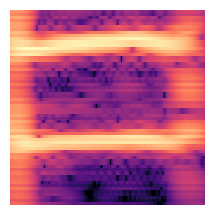

In [4]:
firsttone1 =  "data/tone_perfect/bai1_MV3_MP3.mp3"
librosa_plot(firsttone1)

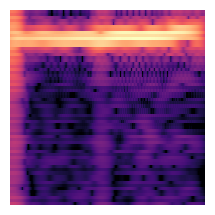

In [5]:
librosa_plot('data/tone_perfect/fan1_FV1_MP3.mp3')

So as we can see first tone results in a very smooth straight line. Male vs. Female voice results in a small diference of the height of the line.

## Visualizing Second Tone

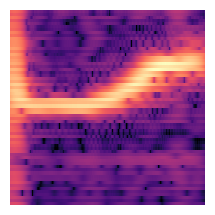

In [6]:
librosa_plot('data/tone_perfect/bao2_FV3_MP3.mp3')

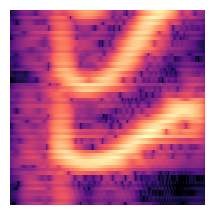

In [7]:
librosa_plot("data/tone_perfect/hai2_MV1_MP3.mp3")

Second Tone is a sharp increase in tone towards the end of the character

## Visualizing 3rd Tone

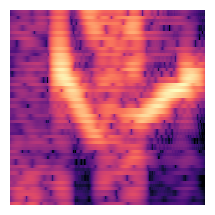

In [8]:
librosa_plot('data/tone_perfect/fou3_FV2_MP3.mp3')

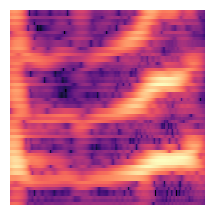

In [9]:
#change this one
librosa_plot("data/tone_perfect/dao3_MV2_MP3.mp3")

3rd tone is the lowest of the 4, results in a deep valley towards the middle of the character. Decrease, then rise again

## Visualizing 4th Tone

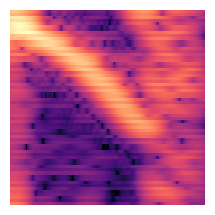

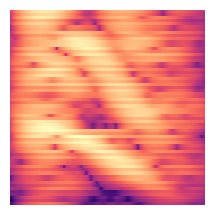

In [10]:

librosa_plot("data/tone_perfect/dai4_FV2_MP3.mp3")
librosa_plot("data/tone_perfect/ai4_MV3_MP3.mp3")

Sharp Decrease from High pitch to Low pitch

## Forvo API

Due to the Uniform Nature of the Data, I decided to pull in some real world examples from Forvo

In [ ]:
from dotenv import load_dotenv
load_dotenv()
FORVO_KEY = os.getenv("FORVO_API")
base_url = f"https://apifree.forvo.com/key/{FORVO_KEY}/"
FORVO_URL = ( base_url + "format/xml/action/word-pronunciations/word/{word}/language/zh") # ENDPOINT FOR CHINESE

QUICK SCRIPT TO CALL FORVO API URL 

Search for common words as specified by the Chinese Index saved in repo as : finalchineseindex.xlsx

In [ ]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import uuid

def forvo_call(character, tone):
    response = requests.get(FORVO_URL.format(word = character))
    if response.ok:
        root = ET.fromstring(response.content)
        # Find all <item> elements and extract the <pathogg> content
        path_mp3 = []
        for item in root.findall('item'):
            mp3 = item.find('pathmp3').text
            path_mp3.append(mp3)
        for i, mp3_url in enumerate(path_mp3):
            mp3_response = requests.get(mp3_url)
            if mp3_response.status_code == 200:
                file_name = f"data/forvo/{tone}_{uuid.uuid4()}.mp3"
                with open(file_name, "wb") as f:
                    f.write(mp3_response.content)
            else:
                print("Failed MP3 Fetch")

    else:
        print("Forvo/Character Not Found")

def get_character_audios():
    #this index contains the most common chinese characters
    index = pd.read_excel("finalchineseindex.xlsx")
    mapping = {'first':1, 'second': 2, 'third': 3, 'fourth': 4}
    for (index, row) in index.iterrows():
        if index > 400: 
            break
        if row['tone'] == 'neutral' or index > 400: 
            continue
        tone = mapping[row['tone']]
        character = row['character']
        forvo_call(character, tone)
    print("Finished Forvo Calls")

get_character_audios()

## TF DATABASE CREATION

- TF Database prefetchs images, ideal for our large 10,000 plus dataset

- Need to save our images into 4 folders representing the 4 different tones under 1 subdirectory

- File Structure: 
    tone folder 
    - 1
    - 2
    - 3
    - 4

In [ ]:
from PIL import Image

# More formal version of librosa_plot earlier
def audio_to_mel_spectrogram(audio_path,output_dir, img_size=(225, 225), low_freq_range=(50, 350)):
    """
    Convert an audio clip to a mel-spectrogram image within a specific frequency range and saves it
    """
    print(output_dir)
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=16000)
    y, _ = librosa.effects.trim(y, top_db=8)

    # Create mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
         y=y, sr=sr, n_fft=2048, hop_length=16, n_mels=64, fmin=low_freq_range[0], fmax=low_freq_range[1]
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    plt.figure(figsize=(2.25, 2.25)) 
    plt.axis('off') 
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=16, x_axis=None, y_axis=None)
    plt.tight_layout()
    # Save as image
    img_path = os.path.join(output_dir, os.path.basename(audio_path).replace('.mp3', '.png'))
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    img = Image.open(img_path).resize(img_size)
    img.save(img_path)
    print(f"Saved mel-spectrogram to {img_path}")

In [ ]:
#This will take at least a couple minutes
output_directory = ("data/tone/{tone}")
for f in os.listdir(data_directory):
  print(f)
  if f.endswith('.mp3'):
    output_dir = output_directory.format(tone = f.split("_")[0][-1])
    audio_to_mel_spectrogram(os.path.join(data_directory, f), output_dir)

In [ ]:
#TF Dataset Creation
realdata_path = 'data/tone' #Folder that containers the 4 subfolders
dataset = tf.keras.utils.image_dataset_from_directory(
    realdata_path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=(225, 225),
    batch_size=32)

## Model Creation: Using TF Keras

- Convolutional Neural Network with 3 Convolution Layers

- Softmax with CCE as loss function

- 3 Layers of Dropout 

In [ ]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation, GaussianNoise

def get_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [ ]:
#Initialization of our Model
class_names = dataset.class_names
input_shape = (225, 225, 3)
classes = len(class_names)
model = get_cnn_model(input_shape, classes)

## Data Normalization

Without normalization, gradients could explode

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

#Map our normalization function to the Dataset
normalized_dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

#Test/Train/Validate Split
#80/10/10
train_size = 0.8 
val_size = 0.1

dataset_size = len(normalized_dataset)
train_dataset = normalized_dataset.take(int(dataset_size * train_size))
val_dataset = normalized_dataset.skip(int(dataset_size * train_size)).take(int(dataset_size * val_size))
test_dataset = normalized_dataset.skip(int(dataset_size * (train_size + val_size)))

In [ ]:
# Create a Checkpoint just in case to save our model to a .keras file
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="final.keras",          
    save_best_only=True,               # Save only the best model
    monitor='val_accuracy',            # Monitor validation accuracy
    mode='max',                        # Save when val_accuracy is maximized
    save_weights_only=False,        
    verbose=1                          
)

## Training Time!

In [ ]:
model.fit(train_dataset, callbacks = [checkpoint], epochs=6, batch_size= 32, verbose=1, validation_data=val_dataset)

# Results: 

- During training, the Validation Loss Seemed to plateau and start to decrease after the 4th epoch, so I will use that model checkpoint
- Reach 97% Accuracy on the Validation Data

In [ ]:
model = tf.keras.models.load_model("final.keras")
model.evaluate(test_dataset)

98% Accuracy on the Test Dataset!

In [ ]:
#Create Confusion Matrix on Test Dataset

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true labels and predictions
y_true = []
y_pred = []

# Iterate through test dataset
for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Directly store class indices
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
num_classes = cm.shape[0]

# 3. Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", 
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. Display classification report
print(classification_report(y_true, y_pred))



Inside this Confusion Matrix (all the tones are shifted down 1)

- 1st Tone (0) 
    - 9 False Negative, leading to the lowest recall with 96% 
    - 6 False Positives
    - Most often confused with Second Tone 

- 2nd Tone (1)
    - 9 False Negatives
    - 7 False Positives
    - 97 % Recall/Precision


- 3rd Tone(2)
    - 5 False Negatives
    - 7 False Positives
    - 98% Recall


- 4th Tone(3)
    - Nearly 100% Recall, with only one value being a False Negative
    - Precision and Accuracy Similar
    - 5 False Positives

I'm happy with these Results, we will try to quantize the model, so we can maybe deploy on AWS Lambda

Can this be Quantized For TFLite?  Lets See!